In [1]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy.fft import fft,ifft

def dbscale(darray):
    if len(np.shape(darray))==3:
        img = 10*np.log10(abs(darray[:,:,0]+1j*darray[:,:,1])**2)
    else:
        img = 10*np.log10(abs(darray[:,:])**2)
    return img

def logScale(slices):
    
    logslices = np.copy(slices)
    nSlices = slices.shape[2]
    logslicesAmp = abs(logslices[:, :, :, 0] + 1j*logslices[:, :, :, 1])
    # and retrieve the phase
    logslicesPhase = np.angle(logslices[:, :, :, 0] + 1j*logslices[:, :, :, 1])
    # reescale amplitude
    logslicesAmp = np.log10(logslicesAmp)
    slicesMax = np.reshape(logslicesAmp.max(axis=(0, 1)), ( 1, 1,nSlices))
    slicesMin = np.reshape(logslicesAmp.min(axis=(0, 1)), ( 1, 1,nSlices))
    logslicesAmp = (logslicesAmp - slicesMin) / (slicesMax - slicesMin)
    # --- here, we could even normalize each slice to 0-1, keeping the original
    # --- limits to rescale after the network processes
    # and redefine the real and imaginary components with the new amplitude and
    # same phase
    logslices[:, :, :, 0] = (np.real(logslicesAmp * np.exp(1j*logslicesPhase)) + 1)/2
    logslices[:, :, :, 1] = (np.imag(logslicesAmp * np.exp(1j*logslicesPhase)) + 1)/2
    
    return logslices, slicesMax, slicesMin

def inverseLogScale(oldslices, slicesMax, slicesMin):
 
    slices = np.copy(oldslices)
    slices = (slices * 2) - 1
    slicesAmp = abs(slices[:, :, :, 0] + 1j*slices[:, :, :, 1])
    slicesPhase = np.angle(slices[:, :, :, 0] + 1j*slices[:, :, :, 1])
    slicesAmp = slicesAmp * (slicesMax - slicesMin) + slicesMin
    slicesAmp = 10**(slicesAmp)
    slices[:, :, :, 0] = np.real(slicesAmp * np.exp(1j*slicesPhase))
    slices[:, :, :, 1] = np.imag(slicesAmp * np.exp(1j*slicesPhase))
    return slices

def inverseLogScaleSummary(oldslices, slicesMax, slicesMin):
 
    slices = np.copy(oldslices)
    slices = (slices * 2) - 1
    slicesAmp = abs(slices[ :, :, 0] + 1j*slices[ :, :, 1])
    slicesPhase = np.angle(slices[ :, :, 0] + 1j*slices[ :, :, 1])
    slicesAmp = slicesAmp * (slicesMax - slicesMin) + slicesMin
    slicesAmp = 10**(slicesAmp)
    slices[:, :, 0] = np.real(slicesAmp * np.exp(1j*slicesPhase))
    slices[:, :, 1] = np.imag(slicesAmp * np.exp(1j*slicesPhase))
    return slices

def normalizePhase(tom):
    tomcx = tom[:,:,:,0]+1j*tom[:,:,:,1]
    amp = abs(tomcx)
    phase = np.angle(tomcx)
    min_fase = phase.min()
    max_fase = phase.max()
    a=-1*np.pi
    b=1*np.pi
    phase_normalized = (phase - min_fase) / (max_fase - min_fase) * (b - a) + a
    tomNormilized = amp*np.exp(1j*phase_normalized)
    return tomNormilized

In [2]:
dataPath = r'E:\DLOCT\Experimental_Data_complex'
# tom = np.load(os.path.join(dataPath,'validationOpticNerve.npy'))
# tomcc = np.load(os.path.join(dataPath,'validationOpticNervecc.npy'))
tom = np.load(os.path.join(dataPath,'depthNail.npy'))
tomcc = np.load(os.path.join(dataPath,'depthNailcc.npy'))
size = 512
initz = 256
initx1 = 0
initx2 = 512
tomHalfinit = tom[initz:initz+size,initx1:initx1+size,:,:]
tomHalfinitcc = tomcc[initz:initz+size,initx1:initx1+size,:,:]
tomHalfinit2 = tom[initz:initz+size,initx2:,:,:]
tomHalfinit2cc = tomcc[initz:initz+size,initx2:,:,:]
tomPhaseNorm = normalizePhase(tom)
tomPhaseNorm = np.stack((tomPhaseNorm.real,tomPhaseNorm.imag),axis=3)
tomPhaseNormcc = normalizePhase(tomcc)
tomPhaseNormcc = np.stack((tomPhaseNormcc.real,tomPhaseNormcc.imag),axis=3)
tomHalfinitPN = tomPhaseNorm[initz:initz+size,initx1:initx1+size,:,:]
tomHalfinitccPN = tomPhaseNormcc[initz:initz+size,initx1:initx1+size,:,:]
tomHalfinit2PN = tomPhaseNorm[initz:initz+size,initx2:,:,:]
tomHalfinit2ccPN = tomPhaseNormcc[initz:initz+size,initx2:,:,:]


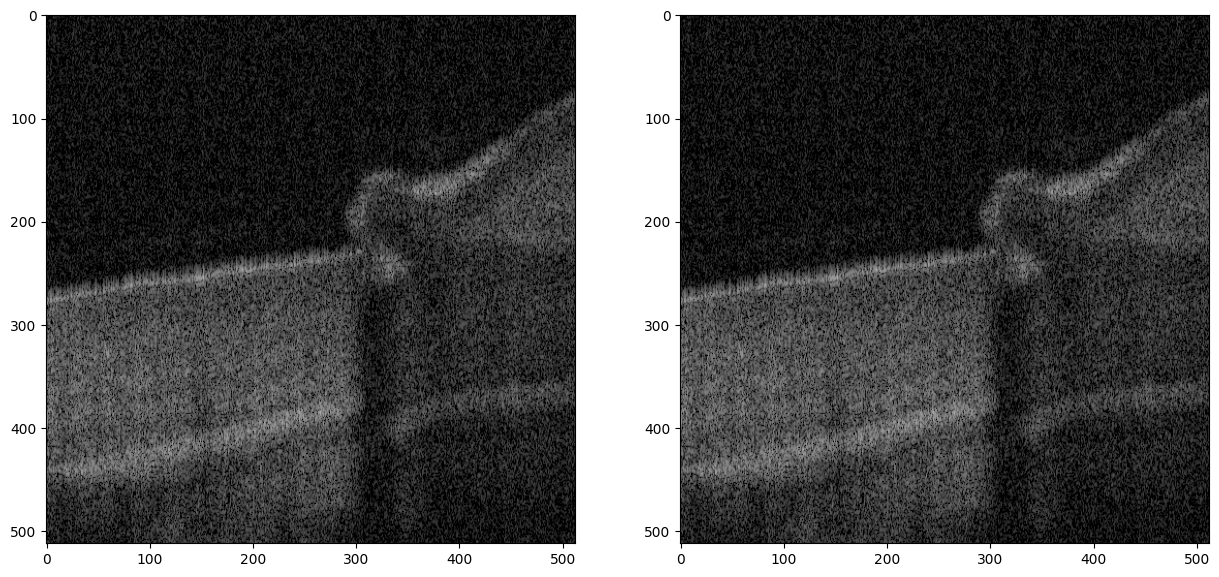

In [3]:
vmin = 70
vmax = 150
cmap='gray'
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(15,10))
axs[0].imshow(dbscale(tomHalfinit2[:,:,0,:]),cmap=cmap,vmin=vmin,vmax=vmax)
axs[0].axis=('off')
axs[1].imshow(dbscale(tomHalfinit2PN[:,:,0,:]),cmap=cmap,vmin=vmin,vmax=vmax)
axs[1].axis=('off')


In [4]:

tomccNorm,imax,imin = logScale(tomHalfinit2cc)
tomccNorm = np.transpose(tomccNorm, (2, 0, 1, 3))
tomccNormPN,imaxpn,iminpn = logScale(tomHalfinit2ccPN)
tomccNormPN = np.transpose(tomccNormPN, (2, 0, 1, 3))
print(tomccNormPN.shape)

(9, 512, 512, 2)


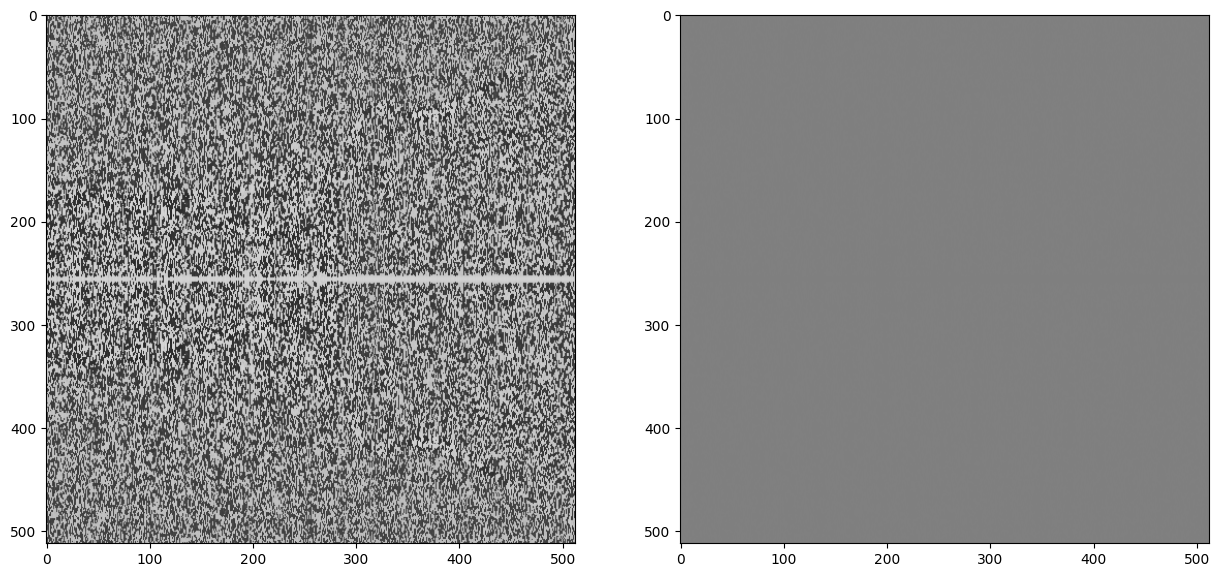

In [5]:
vmin = 0
vmax = 1
cmap='gray'
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(15,10))
axs[0].imshow((tomccNorm[0,:,:,1]),cmap=cmap,vmin=vmin,vmax=vmax)
axs[0].axis=('off')
axs[1].imshow((tomccNormPN[0,:,:,1]),cmap=cmap,vmin=vmin,vmax=vmax)
axs[1].axis=('off')

In [14]:
path = r'E:\models\cxpix2pixcomplexdbscale3\models'
modelName = 'model_048158.h5'
model = tf.keras.models.load_model(os.path.join(path,modelName), compile=False)



In [15]:
tomPredict = np.array(model.predict(tomccNorm, batch_size=1), dtype='float32')
tomPredictreordered = np.transpose(tomPredict, (1, 2, 0, 3))
tomPredictFullScale = inverseLogScale(tomPredictreordered,imax,imin)

tomPredictPN = np.array(model.predict(tomccNormPN, batch_size=1), dtype='float32')
tomPredictreorderedPN = np.transpose(tomPredictPN, (1, 2, 0, 3))
tomPredictFullScalePN = inverseLogScale(tomPredictreorderedPN,imax,imin)

9/9 [==============================] - 1s 151ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_27992\3919101982.py:10: RuntimeWarning: overflow encountered in square
  img = 10*np.log10(abs(darray[:,:,0]+1j*darray[:,:,1])**2)


Text(0.5, 1.0, 'Target')

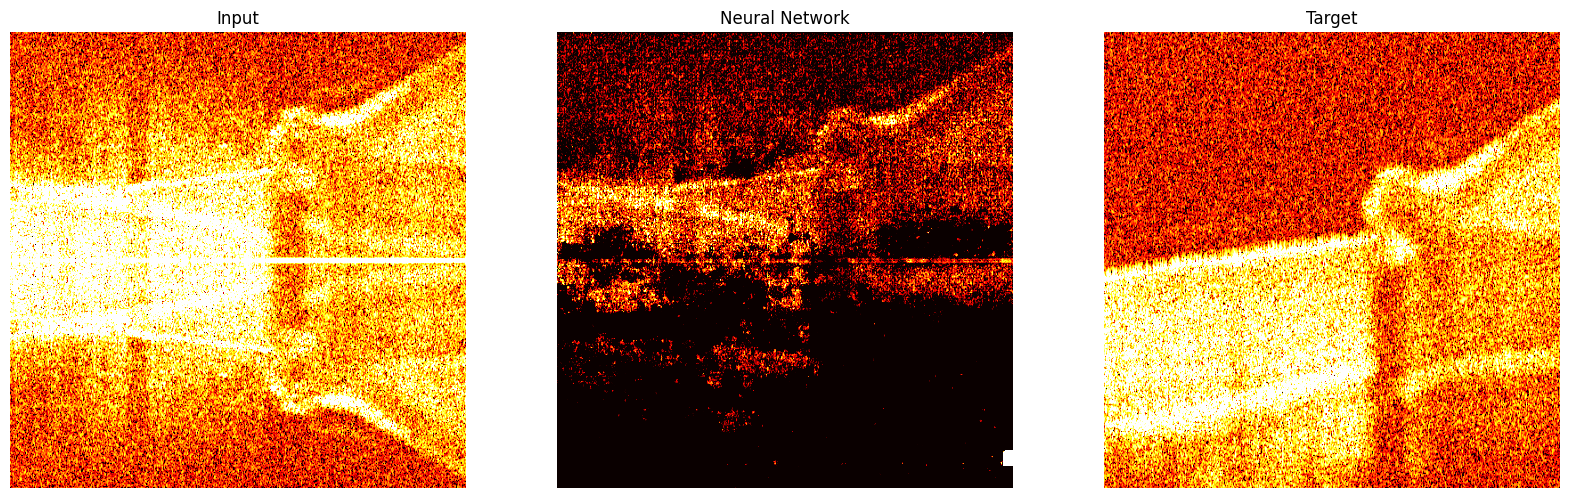

In [23]:
vmax = 100
vmin = 60
bscan = 0
fig,axs = plt.subplots(ncols=3,nrows=1,figsize=(20,15))
axs[0].imshow(dbscale(tomHalfinit2cc[:,:,bscan,:]),cmap='hot',vmax=vmax,vmin=vmin)
axs[0].axis('off')
axs[0].set_title('Input')
axs[1].imshow(dbscale(tomPredictFullScale[:,:,bscan,:]),cmap='hot',vmax=vmax,vmin=vmin)
axs[1].axis('off')
axs[1].set_title('Neural Network')
axs[2].imshow(dbscale(tomHalfinit2[:,:,bscan,:]),cmap='hot',vmax=vmax,vmin=vmin)
axs[2].axis('off')
axs[2].set_title('Target')

C:\Users\USER\AppData\Local\Temp\ipykernel_27992\3919101982.py:10: RuntimeWarning: overflow encountered in square
  img = 10*np.log10(abs(darray[:,:,0]+1j*darray[:,:,1])**2)


Text(0.5, 1.0, 'Target')

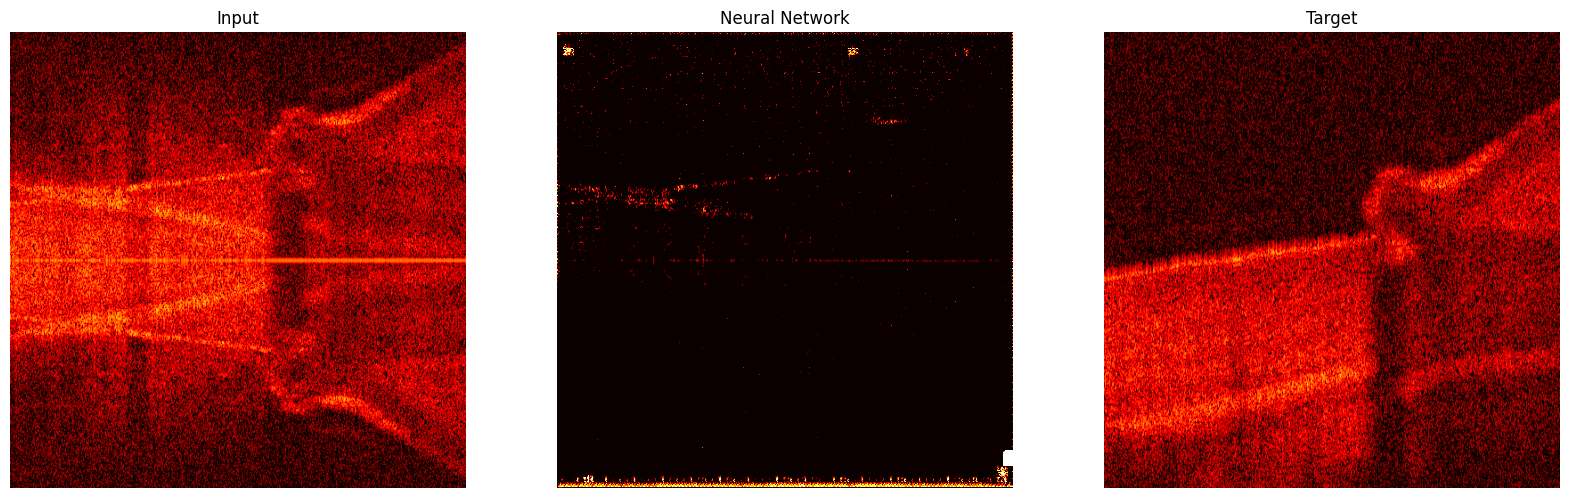

In [17]:
vmax = 150
vmin = 70
bscan = 0
fig,axs = plt.subplots(ncols=3,nrows=1,figsize=(20,15))
axs[0].imshow(dbscale(tomHalfinit2cc[:,:,bscan,:]),cmap='hot',vmax=vmax,vmin=vmin)
axs[0].axis('off')
axs[0].set_title('Input')
axs[1].imshow(dbscale(tomPredictFullScalePN[:,:,bscan,:]),cmap='hot',vmax=vmax,vmin=vmin)
axs[1].axis('off')
axs[1].set_title('Neural Network')
axs[2].imshow(dbscale(tomHalfinit2[:,:,bscan,:]),cmap='hot',vmax=vmax,vmin=vmin)
axs[2].axis('off')
axs[2].set_title('Target')

In [18]:

def extract_dimensions(file_name):
    parts = file_name.split('_')
    dimensions = []
    for part in parts:
        if 'z=' in part or 'x=' in part or 'y=' in part:
            number = int(part.split('=')[-1])
            dimensions.append(number)
    return tuple(dimensions)

def read_tomogram(file_path, dimensions):
    depth, height, width = dimensions
    with open(file_path, 'rb') as file:
        tomogram = np.fromfile(file, dtype='single')
        tomogram = tomogram.reshape((depth, height, width),order='F')
    return tomogram

pathcomplex = r'C:\Users\USER\Documents\GitHub\Simulated_Data_Complex\validation'
artifact_files = os.listdir(pathcomplex)
for imag_file, real_file in zip(artifact_files[::2], artifact_files[1::2]):
    real_file_path = os.path.join(pathcomplex, real_file)
    imag_file_path = os.path.join(pathcomplex, imag_file)
    dimensions = extract_dimensions(real_file[:-4])
    tomReal = read_tomogram(real_file_path, dimensions)
    tomImag = read_tomogram(imag_file_path, dimensions)
    tomS = np.stack((tomReal,tomImag),axis=3)
    del tomImag, tomReal

tomccsyntetic = ifft(tomS[:,:,:,0]+1j*tomS[:,:,:,1],axis=0)
tomccsyntetic = fft(tomccsyntetic.real,axis=0)
tomccsyntetic = np.stack((tomccsyntetic.real,tomccsyntetic.imag),axis=3)
tomccNormS,imaxS,iminS = logScale(tomccsyntetic)
tomccNormS = np.transpose(tomccNormS, (2, 0, 1, 3))

In [19]:
tomPredictS = np.array(model.predict(tomccNormS, batch_size=1), dtype='float32')
tomPredictreorderedS = np.transpose(tomPredictS, (1, 2, 0, 3))
tomPredictFullScaleS = inverseLogScale(tomPredictreorderedS,imaxS,iminS)

8/8 [==============================] - 1s 174ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_27992\3919101982.py:10: RuntimeWarning: overflow encountered in square
  img = 10*np.log10(abs(darray[:,:,0]+1j*darray[:,:,1])**2)


Text(0.5, 1.0, 'Target')

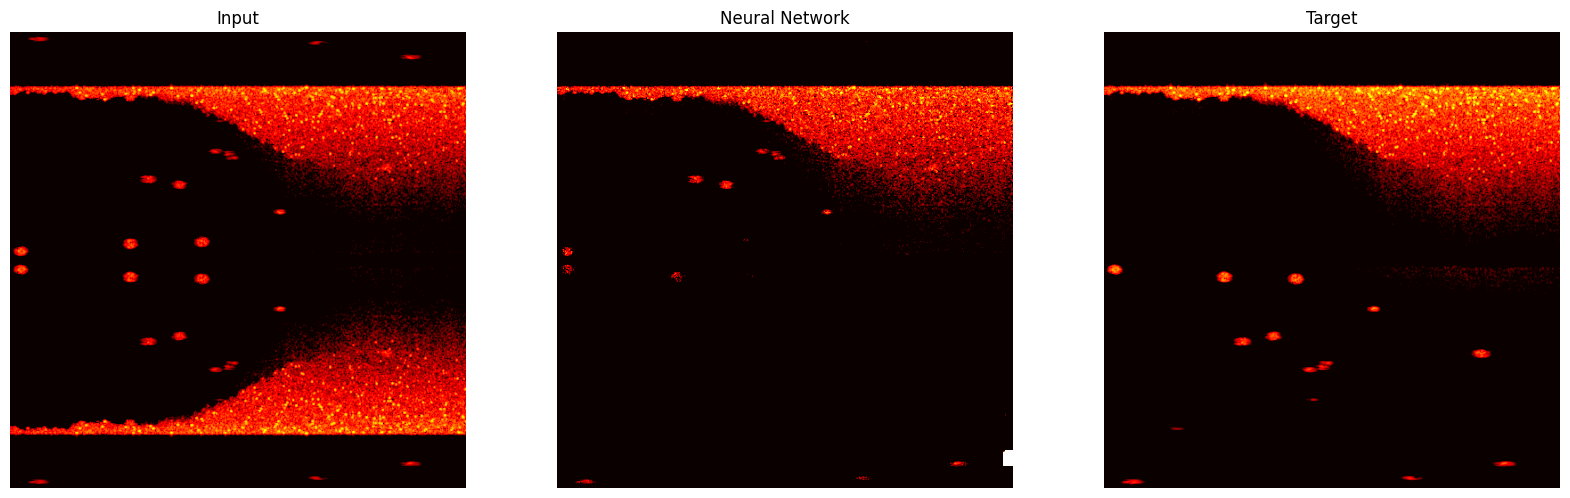

In [20]:
vmin = 70
vmax = 150
bscan = 0
fig,axs = plt.subplots(ncols=3,nrows=1,figsize=(20,15))
axs[0].imshow(dbscale(tomccsyntetic[:,:,bscan,:]),cmap='hot',vmin=vmin,vmax=vmax)
axs[0].axis('off')
axs[0].set_title('Input')
axs[1].imshow(dbscale(tomPredictFullScaleS[:,:,bscan,:]+c),cmap='hot',vmin=vmin,vmax=vmax)
axs[1].axis('off')
axs[1].set_title('Neural Network')
axs[2].imshow(dbscale(tomS[:,:,bscan,:]),cmap='hot',vmin=vmin,vmax=vmax)
axs[2].axis('off')
axs[2].set_title('Target')
